In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, Concatenate, Dropout
from sklearn.model_selection import train_test_split
import random
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import l1

# **Sistema de recomendación - Movies**

In [ ]:
df = pd.read_csv('movies_predictions20.csv')
df = df.drop(columns=['emotion', 'bert_input'])
df.head()

,movieId,title,genres,userId,rating,timestamp,year,predicted_emotions
0,1,Toy Story,"Action, Children",1,4.0,2000-07-30 18:45:03,1995,Heartwarming; Inspiring
1,1,Toy Story,"Action, Children",5,4.0,1996-11-08 06:36:02,1995,Heartwarming; Inspiring
2,1,Toy Story,"Action, Children",7,4.5,2005-01-25 06:52:26,1995,Heartwarming; Inspiring
3,1,Toy Story,"Action, Children",15,2.5,2017-11-13 12:59:30,1995,Heartwarming; Inspiring
4,1,Toy Story,"Action, Children",17,4.5,2011-05-18 05:28:03,1995,Heartwarming; Inspiring


## **Construcción y entrenamiento del modelo**

In [ ]:
# ------------------ Preprocesamiento ------------------

# Mapear movieId y userId a índices consecutivos
movie_encoder = LabelEncoder()
df['movieId'] = movie_encoder.fit_transform(df['movieId'])
n_movies = df['movieId'].nunique()

user_encoder = LabelEncoder()
df['userId'] = user_encoder.fit_transform(df['userId'])
n_users = df['userId'].nunique()

# One-hot encoding para géneros
genres_encoder = OneHotEncoder()
genres_encoded = genres_encoder.fit_transform(df['genres'].values.reshape(-1, 1)).toarray()

# One-hot encoding para emociones
emotions_encoder = OneHotEncoder()
emotions_encoded = emotions_encoder.fit_transform(df['predicted_emotions'].values.reshape(-1, 1)).toarray()

# Normalización del año
df['year_norm'] = (df['year'] - df['year'].min()) / (df['year'].max() - df['year'].min())

# ------------------ Modelo con Deep Learning ------------------

# Definir inputs
user_input = Input(shape=(1,), name='User_Input')
movie_input = Input(shape=(1,), name='Movie_Input')
genres_input = Input(shape=(genres_encoded.shape[1],), name='Genres_Input')
emotions_input = Input(shape=(emotions_encoded.shape[1],), name='Emotions_Input')
year_input = Input(shape=(1,), name='Year_Input')

# Embeddings
user_embedding = Embedding(input_dim=n_users, output_dim=min(50, int(np.sqrt(n_users))), name='User_Embedding')(user_input)
movie_embedding = Embedding(input_dim=n_movies, output_dim=min(50, int(np.sqrt(n_movies))), name='Movie_Embedding')(movie_input)


# Flatten embeddings
user_vec = Flatten()(user_embedding)
movie_vec = Flatten()(movie_embedding)

# Concatenate features
concat = Concatenate()([user_vec, movie_vec, genres_input, emotions_input, year_input])

# Fully connected layers
dense = Dense(128, activation='selu', kernel_initializer='he_normal', kernel_regularizer=l2(0.01))(concat)
dense = Dropout(0.5)(dense)
dense = Dense(64, activation='selu',  kernel_regularizer=l2(0.01))(dense)
dense = Dropout(0.5)(dense)
dense = Dense(32, activation='selu', kernel_regularizer=l2(0.01))(dense)
dense = Dropout(0.5)(dense)
output = Dense(1, activation='linear', name='Rating_Output')(dense)

# Modelo
model = Model(inputs=[user_input, movie_input, genres_input, emotions_input, year_input], outputs=output)
optimizer = Adam(learning_rate=0.0001)  # Probar con una tasa de aprendizaje más baja
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Resumen del modelo
model.summary()

# ------------------ Entrenamiento ------------------

# Entrenar el modelo
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    [df['userId'].values, df['movieId'].values, genres_encoded, emotions_encoded, df['year_norm'].values],
    df['rating'].values,
    batch_size=32,
    epochs=30,
    validation_split=0.2,
    callbacks=[early_stopping]
)

# ------------------ Predicción ------------------

# Ejemplo de predicción
predicted_ratings = model.predict(
    [df['userId'].values, df['movieId'].values, genres_encoded, emotions_encoded, df['year_norm'].values]
)

print("Ratings predichos:", predicted_ratings)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ User_Input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Movie_Input (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ User_Embedding            │ (None, 1, 24)          │         14,640 │ User_Input[0][0]       │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Movie_Embedding           │ (None, 1, 50)          │        182,450 │ Movie_Input[0][0]      │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 24)             │              0 │ User_Embedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 50)             │              0 │ Movie_Embedding[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Genres_Input (InputLayer) │ (None, 43)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Emotions_Input            │ (None, 103)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Year_Input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 221)            │              0 │ flatten[0][0],         │
│                           │                        │                │ flatten_1[0][0],       │
│                           │                        │                │ Genres_Input[0][0],    │
│                           │                        │                │ Emotions_Input[0][0],  │
│                           │                        │                │ Year_Input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │         28,416 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │          8,256 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64)             │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 32)             │          2,080 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 32)             │              0 │ dense_2[0][0]          │
├──────────────────────

 Total params: 235,875 (921.39 KB)

 Trainable params: 235,875 (921.39 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
2257/2257 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - loss: 8.1809 - mae: 1.7388 - val_loss: 3.5236 - val_mae: 0.7579
Epoch 2/30
2257/2257 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - loss: 4.3610 - mae: 1.1671 - val_loss: 2.5154 - val_mae: 0.7072
Epoch 3/30
2257/2257 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 2.9774 - mae: 0.9817 - val_loss: 1.8569 - val_mae: 0.6901
Epoch 4/30
2257/2257 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 2.1848 - mae: 0.8890 - val_loss: 1.4514 - val_mae: 0.6920
Epoch 5/30
2257/2257 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 1.6934 - mae: 0.8359 - val_loss: 1.2117 - val_mae: 0.7071
Epoch 6/30
2257/2257 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 1.3903 - mae: 0.8042 - val_loss: 1.0698 - val_mae: 0.7180
Epoch 7/30
2257/2257 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 1.2083 - mae: 0.7868 - val_loss: 0.9747 - val_mae: 0.7148
Epoch 8/30
2257/2257 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 1.0980 - mae: 0.7734 - val_loss: 0.9619 - val_mae: 0.7408
Epoch 9/30
2257/2257 ━━━━━━━━━━━

In [ ]:
# Mostrar valores únicos de las calificaciones predichas desescaladas
unique_ratings = np.unique(predicted_ratings)
print("Valores únicos en las calificaciones predichas:", unique_ratings)


Valores únicos en las calificaciones predichas: [0.6699362  0.96477795 1.012712   ... 5.1671295  5.1746655  5.237111  ]


### Evaluación del modelo:

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

mae = mean_absolute_error(df['rating'].values, predicted_ratings)
rmse = np.sqrt(mean_squared_error(df['rating'].values, predicted_ratings))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")


MAE: 0.6460649794666528
RMSE: 0.8377146525249776


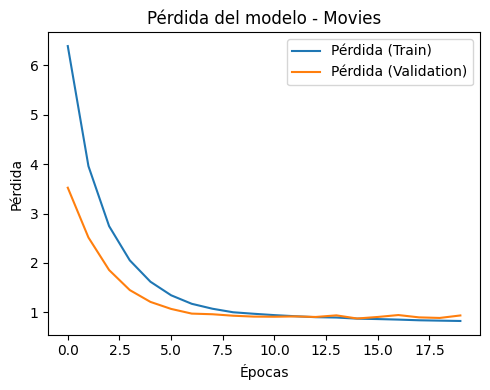

In [ ]:
import matplotlib.pyplot as plt

# Graficar la función de pérdida
plt.figure(figsize=(5, 4))
plt.plot(history.history['loss'], label='Pérdida (Train)')
plt.plot(history.history['val_loss'], label='Pérdida (Validation)')
plt.title('Pérdida del modelo - Movies')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Mostrar la gráfica
plt.tight_layout()
plt.show()


## **Función para utilizar el sistema de recomendación**

In [ ]:
def recommend_movies(genre, emotion, top_n=1):
    # Generar un user_id aleatorio dentro del rango de userId
    user_id = random.choice(df['userId'].values)  # Elige un userId aleatorio

    # Filtrar películas por género y emoción
    genre_mask = df['genres'].str.contains(genre, case=False)
    emotion_mask = df['predicted_emotions'].str.contains(emotion, case=False)
    filtered_movies = df[genre_mask & emotion_mask]

    if filtered_movies.empty:
        return "No se encontraron películas para este género y emoción."

    # Preparar entradas para el modelo
    user_array = np.array([user_id] * len(filtered_movies))
    movie_array = filtered_movies['movieId'].values
    genres_array = genres_encoder.transform(filtered_movies['genres'].values.reshape(-1, 1)).toarray()
    emotions_array = emotions_encoder.transform(filtered_movies['predicted_emotions'].values.reshape(-1, 1)).toarray()

    # Normalizar el año de la película
    year_array = (filtered_movies['year'] - df['year'].min()) / (df['year'].max() - df['year'].min())

    # Convertir las entradas a tensores
    import tensorflow as tf
    user_array = tf.convert_to_tensor(user_array)
    movie_array = tf.convert_to_tensor(movie_array)
    genres_array = tf.convert_to_tensor(genres_array)
    emotions_array = tf.convert_to_tensor(emotions_array)
    year_array = tf.convert_to_tensor(year_array)

    # Predecir calificaciones escaladas
    predicted_ratings = model.predict([user_array, movie_array, genres_array, emotions_array, year_array])

    # Añadir calificaciones desescaladas al DataFrame
    filtered_movies['predicted_rating'] = predicted_ratings
    filtered_movies['predicted_rating'] = filtered_movies['predicted_rating'].round(2)

    # Ordenar películas por calificación predicha
    recommended_movies = filtered_movies.sort_values(by='predicted_rating', ascending=False)

    return recommended_movies[['title', 'predicted_rating']].head(top_n)

## ----------------------------------------------------- Ingresar género y emoción para generar la recomendación ----------------------------
# Ejemplo de recomendación
genre = "Action"
emotion = "Happy"

recommendations = recommend_movies(genre, emotion)
recommendations


252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


<ipython-input-9-ea75a700112f>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_movies['predicted_rating'] = predicted_ratings
<ipython-input-9-ea75a700112f>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_movies['predicted_rating'] = filtered_movies['predicted_rating'].round(2)


,title,predicted_rating
24418,"Princess Bride, The",4.1


### Guardar el modelo para cargarlo y utilizarlo nuevamente en otro **entorno**

In [ ]:
# Guardar el modelo
model.save('movie_recommendation_model.h5')


In [ ]:
from tensorflow.keras.models import load_model

# Cargar el modelo
model = load_model('movie_recommendation_model.h5')


# **Sistema de recomendación - Music**

In [ ]:
df1 = pd.read_csv('music_predictions_final_.csv')
df1 = df1.drop(columns=['emotion', 'bert_input', 'Genre'])
# Crear un diccionario que asigna números únicos a los valores únicos de la columna 'Username'
user_mapping = {username: idx for idx, username in enumerate(df1['Username'].unique())}

# Reemplazar los valores de 'Username' con los IDs únicos y renombrar la columna
df1['Username'] = df1['Username'].map(user_mapping)
df1.rename(columns={'Username': 'user_id'}, inplace=True)
df1.head()

,user_id,Artist,Track,Album,Date,Time,rating,standard_genres,predicted_emotions
0,0,Isobel Campbell,The Circus Is Leaving Town,Ballad of the Broken Seas,31 Jan 2021,0 days 23:36:00,4.5,"['Drama', 'Nostalgic']",Nostalgic; Sad
1,0,Isobel Campbell,Dusty Wreath,Ballad of the Broken Seas,31 Jan 2021,0 days 23:32:00,5.0,"['Drama', 'Nostalgic']",Nostalgic; Sad
2,0,Isobel Campbell,Honey Child What Can I Do?,Ballad of the Broken Seas,31 Jan 2021,0 days 23:28:00,2.5,"['Drama', 'Nostalgic']",Nostalgic; Sad
3,0,Isobel Campbell,It's Hard To Kill A Bad Thing,Ballad of the Broken Seas,31 Jan 2021,0 days 23:25:00,2.5,"['Drama', 'Nostalgic']",Inspiring; Sad
4,0,Isobel Campbell,Saturday's Gone,Ballad of the Broken Seas,31 Jan 2021,0 days 23:21:00,3.5,"['Drama', 'Nostalgic']",Nostalgic; Sad


In [ ]:
print("Antes de eliminar NaN:")
print(df1.isnull().sum())

# Eliminar NaN
df1 = df1.dropna()

print("Después de eliminar NaN:")
print(df1.isnull().sum())


Antes de eliminar NaN:
user_id                 0
Artist                  0
Track                   0
Album                   0
Date                    0
Time                    0
rating                  0
standard_genres         0
predicted_emotions    474
dtype: int64
Después de eliminar NaN:
user_id               0
Artist                0
Track                 0
Album                 0
Date                  0
Time                  0
rating                0
standard_genres       0
predicted_emotions    0
dtype: int64


In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55717 entries, 0 to 56190
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             55717 non-null  int64  
 1   Artist              55717 non-null  object 
 2   Track               55717 non-null  object 
 3   Album               55717 non-null  object 
 4   Date                55717 non-null  object 
 5   Time                55717 non-null  object 
 6   rating              55717 non-null  float64
 7   standard_genres     55717 non-null  object 
 8   predicted_emotions  55717 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 4.3+ MB


In [ ]:
from tensorflow.keras.optimizers import AdamW
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.layers import BatchNormalization

# ------------------ Preprocesamiento ------------------

# Mapear track y artist a índices consecutivos
# Codificar Artist y Track con LabelEncoder
artist_encoder = LabelEncoder()
df1['Artist'] = artist_encoder.fit_transform(df1['Artist'])
n_artists = df1['Artist'].nunique()

track_encoder = LabelEncoder()
df1['Track'] = track_encoder.fit_transform(df1['Track'])
n_tracks = df1['Track'].nunique()


# One-hot encoding para géneros estándar
genre_encoder = MultiLabelBinarizer()
genres_encoded = genre_encoder.fit_transform(df1['standard_genres'].apply(eval))  # 'eval' convierte la cadena en lista

# One-hot encoding para emociones
emotions_encoder = OneHotEncoder()
emotions_encoded = emotions_encoder.fit_transform(df1['predicted_emotions'].fillna('').values.reshape(-1, 1)).toarray()

# Normalización de la fecha: convertir Date en una fecha numérica
df1['Date'] = pd.to_datetime(df1['Date'], format='%d %b %Y')  # Asegúrate de que Date esté en formato datetime
df1['date_norm'] = (df1['Date'] - df1['Date'].min()) / (df1['Date'].max() - df1['Date'].min())

# ------------------ Modelo con Deep Learning ------------------

# Definir entradas
user_input = Input(shape=(1,), name='User_Input')  # Entrada para user_id
track_input = Input(shape=(1,), name='Track_Input')  # Entrada para Track codificado
artist_input = Input(shape=(1,), name='Artist_Input')  # Entrada para Artist codificado
genre_input = Input(shape=(genres_encoded.shape[1],), name='Genre_Input')  # Entrada para géneros musicales codificados
emotions_input = Input(shape=(emotions_encoded.shape[1],), name='Emotions_Input')  # Entrada para emociones predichas
date_input = Input(shape=(1,), name='Date_Input')  # Entrada para fecha normalizada

# Embeddings para artista y canción
artist_embedding = Embedding(input_dim=n_artists, output_dim=32, name='Artist_Embedding')(artist_input)
track_embedding = Embedding(input_dim=n_tracks, output_dim=32, name='Track_Embedding')(track_input)

# Aplanar las representaciones embebidas
artist_vec = Flatten()(artist_embedding)
track_vec = Flatten()(track_embedding)

# Concatenar todas las entradas
concat = Concatenate()([user_input, artist_vec, track_vec, genre_input, emotions_input, date_input])

# Fully connected layers
dense = Dense(128, activation='selu', kernel_regularizer=l2(0.01))(concat)
dense = Dropout(0.5)(dense)
dense = BatchNormalization()(dense)
dense = Dense(64, activation='selu', kernel_regularizer=l2(0.01))(dense)
dense = Dropout(0.5)(dense)
dense = BatchNormalization()(dense)
dense = Dense(32, activation='selu', kernel_regularizer=l2(0.01))(dense)
dense = Dropout(0.5)(dense)
dense = BatchNormalization()(dense)
output = Dense(1, activation='linear', name='Rating_Output')(dense)

# Crear el modelo
model = Model(inputs=[user_input, track_input, artist_input, genre_input, emotions_input, date_input], outputs=output)
#optimizer = AdamW(learning_rate=1e-4, weight_decay=1e-5)
from tensorflow.keras.optimizers import RMSprop

optimizer = AdamW(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Resumen del modelo
model.summary()

# ------------------ Entrenamiento ------------------

# Entrenar el modelo
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Entrenamiento con la variable escalada
history = model.fit(
    [df1['user_id'].values, df1['Track'].values, df1['Artist'].values, genres_encoded, emotions_encoded, df1['date_norm'].values],
    df1['rating'].values,  # Usar el rating escalado
    batch_size=64,
    epochs=30,
    validation_split=0.2,
    callbacks=[early_stopping]
)



# ------------------ Predicción ------------------

# # Ejemplo de predicción
predicted_ratings = model.predict(
    [df1['user_id'].values, df1['Track'].values, df1['Artist'].values, genres_encoded, emotions_encoded, df1['date_norm'].values]
)

print("Ratings predichos:", predicted_ratings)

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Artist_Input (InputLayer) │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Track_Input (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Artist_Embedding          │ (None, 1, 32)          │        363,808 │ Artist_Input[0][0]     │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Track_Embedding           │ (None, 1, 32)          │        864,928 │ Track_Input[0][0]      │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ User_Input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_32 (Flatten)      │ (None, 32)             │              0 │ Artist_Embedding[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_33 (Flatten)      │ (None, 32)             │              0 │ Track_Embedding[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Genre_Input (InputLayer)  │ (None, 9)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Emotions_Input            │ (None, 289)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Date_Input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_16            │ (None, 364)            │              0 │ User_Input[0][0],      │
│ (Concatenate)             │                        │                │ flatten_32[0][0],      │
│                           │                        │                │ flatten_33[0][0],      │
│                           │                        │                │ Genre_Input[0][0],     │
│                           │                        │                │ Emotions_Input[0][0],  │
│                           │                        │                │ Date_Input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_43 (Dense)          │ (None, 128)            │         46,720 │ concatenate_16[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_35 (Dropout)      │ (None, 128)            │              0 │ dense_43[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128)            │            512 │ dropout_35[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_44 (Dense)          │ (None, 64)             │          8,256 │ batch_normalization[0… │
├──────────────────────

 Total params: 1,286,721 (4.91 MB)

 Trainable params: 1,286,273 (4.91 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/30
697/697 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 13.3604 - mae: 2.7524 - val_loss: 9.3970 - val_mae: 2.2569
Epoch 2/30
697/697 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - loss: 9.5471 - mae: 2.2618 - val_loss: 6.6384 - val_mae: 1.7715
Epoch 3/30
697/697 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 7.1192 - mae: 1.8715 - val_loss: 4.7182 - val_mae: 1.4364
Epoch 4/30
697/697 ━━━━━━━━━━━━━━━━━━━━ 29s 29ms/step - loss: 5.5048 - mae: 1.6032 - val_loss: 3.8532 - val_mae: 1.2995
Epoch 5/30
697/697 ━━━━━━━━━━━━━━━━━━━━ 36s 22ms/step - loss: 4.7653 - mae: 1.4815 - val_loss: 3.5412 - val_mae: 1.2556
Epoch 6/30
697/697 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - loss: 4.3255 - mae: 1.4123 - val_loss: 3.4019 - val_mae: 1.2500
Epoch 7/30
697/697 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - loss: 4.0632 - mae: 1.3870 - val_loss: 3.2950 - val_mae: 1.2510
Epoch 8/30
697/697 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - loss: 3.8358 - mae: 1.3559 - val_loss: 3.2098 - val_mae: 1.2511
Epoch 9/30
697/697 ━━━━━━━━━━━━━━━━━━━━

KeyboardInterrupt: 

In [ ]:
# Mostrar valores únicos de las calificaciones predichas desescaladas
unique_ratings = np.unique(predicted_ratings)
print("Valores únicos en las calificaciones predichas:", unique_ratings)


Valores únicos en las calificaciones predichas: [-5.3444922e-02 -3.1454861e-03  4.6109870e-02 ...  5.2651339e+00
  5.2969193e+00  5.3129849e+00]


In [ ]:
# Resumen estadístico de las calificaciones predichas
import numpy as np
print("Estadísticas de las calificaciones predichas:")
print("Mínimo:", np.min(predicted_ratings))
print("Máximo:", np.max(predicted_ratings))
print("Media:", np.mean(predicted_ratings))
print("Desviación estándar:", np.std(predicted_ratings))


Estadísticas de las calificaciones predichas:
Mínimo: -0.053444922
Máximo: 5.312985
Media: 2.7186766
Desviación estándar: 1.1983361


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

mae = mean_absolute_error(df2['rating'].values, predicted_ratings)
rmse = np.sqrt(mean_squared_error(df2['rating'].values, predicted_ratings))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")


MAE: 0.4357611177375225
RMSE: 0.7239756035512585


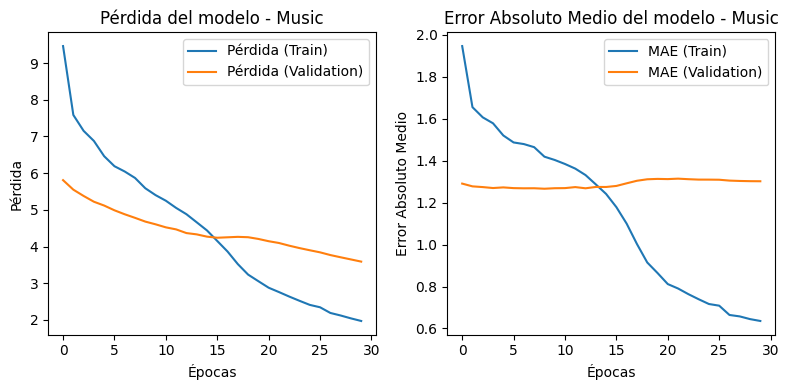

In [ ]:
import matplotlib.pyplot as plt
# Graficar la función de pérdida y la métrica de error absoluto medio
plt.figure(figsize=(8, 4))

# Pérdida de entrenamiento
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida (Train)')
plt.plot(history.history['val_loss'], label='Pérdida (Validation)')
plt.title('Pérdida del modelo - Music')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Métrica de error absoluto medio
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='MAE (Train)')
plt.plot(history.history['val_mae'], label='MAE (Validation)')
plt.title('Error Absoluto Medio del modelo - Music')
plt.xlabel('Épocas')
plt.ylabel('Error Absoluto Medio')
plt.legend()

# Mostrar las gráficas
plt.tight_layout()
plt.show()

In [ ]:
def recommend_music(genre, emotion, top_n=1):
    # Generar un user_id aleatorio dentro del rango de userId
    user_id = random.choice(df1['user_id'].values)

    # Filtrar canciones por género y emoción
    genre_mask = df1['standard_genres'].str.contains(genre, case=False)
    emotion_mask = df1['predicted_emotions'].str.contains(emotion, case=False)
    filtered_tracks = df1[genre_mask & emotion_mask]

    if filtered_tracks.empty:
        return "No se encontraron canciones para este género y emoción."

    # Preparar entradas para el modelo
    user_array = np.array([user_id] * len(filtered_tracks))
    track_array = filtered_tracks['Track'].values
    artist_array = filtered_tracks['Artist'].values
    genres_array = genre_encoder.transform(filtered_tracks['standard_genres'].values.reshape(-1, 1)).toarray()
    emotions_array = emotions_encoder.transform(filtered_tracks['predicted_emotions'].values.reshape(-1, 1)).toarray()
    date_array = (filtered_tracks['Date'] - df1['Date'].min()) / (df1['Date'].max() - df1['Date'].min())  # Normalización

    # Predecir calificaciones
    predicted_ratings = model.predict([user_array, track_array, artist_array, genres_array, emotions_array, date_array])

    # Añadir calificaciones predichas al DataFrame
    filtered_tracks['predicted_rating'] = predicted_ratings

    # Ordenar canciones por calificación predicha
    recommended_tracks = filtered_tracks.sort_values(by='predicted_rating', ascending=False)

    return recommended_tracks[['Track', 'predicted_rating']].head(top_n)

## ----------------------------------------------------- Ingresar género y emoción para generar la recomendación ----------------------------
# Ejemplo de recomendación
genre = "Drama"
emotion = "Nostalgic"

recommendations = recommend_music(genre, emotion)
recommendations


# **Sistema de recomendación - Netflix**

In [ ]:
df2 = pd.read_csv('netflix_predictions30.csv')
df2 = df2.drop(columns=['emotion', 'bert_input'])
df2.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,description,genres,age_rating,predicted_emotions
0,s1,TV Show,3%,Desconocido,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,2020-08-14,2020,3.0,4 Seasons,In a future where the elite inhabit an island ...,"International TV Shows, TV Dramas",TV-MA,Adventurous; Suspenseful
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,2016-12-23,2016,0.5,93 min,After a devastating earthquake hits Mexico Cit...,"Dramas, International Movies",TV-MA,Inspiring; Sad
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,2018-12-20,2011,3.5,78 min,"When an army recruit is found dead, his fellow...","Horror Movies, International Movies",R,Scared; Suspenseful
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,2017-11-16,2009,0.5,80 min,"In a postapocalyptic world, rag-doll robots hi...","Action & Adventure, Independent Movies",PG-13,Adventurous; Suspenseful
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,2020-01-01,2008,0.5,123 min,A brilliant group of students become card-coun...,Dramas,PG-13,Inspiring; Suspenseful


In [ ]:
df2.rename(columns={'show_id': 'user_id'}, inplace=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7373 entries, 0 to 7372
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             7373 non-null   object 
 1   type                7373 non-null   object 
 2   title               7373 non-null   object 
 3   director            7373 non-null   object 
 4   cast                7373 non-null   object 
 5   country             7373 non-null   object 
 6   date_added          7373 non-null   object 
 7   release_year        7373 non-null   int64  
 8   rating              7373 non-null   float64
 9   duration            7373 non-null   object 
 10  description         7373 non-null   object 
 11  genres              7373 non-null   object 
 12  age_rating          7373 non-null   object 
 13  predicted_emotions  7368 non-null   object 
dtypes: float64(1), int64(1), object(12)
memory usage: 806.5+ KB


In [ ]:
# ------------------ Preprocesamiento ------------------

# Mapear `user_id` y `title` a índices consecutivos
user_encoder = LabelEncoder()
df2['user_id'] = user_encoder.fit_transform(df2['user_id'])
n_users = df2['user_id'].nunique()

title_encoder = LabelEncoder()
df2['title'] = title_encoder.fit_transform(df2['title'])
n_titles = df2['title'].nunique()

# Dividir los géneros en listas
df2['genres'] = df2['genres'].str.split(', ')

# Usar MultiLabelBinarizer para codificar los géneros
genres_encoder = MultiLabelBinarizer()
genres_encoded = genres_encoder.fit_transform(df2['genres'])

# One-hot encoding para emociones
emotions_encoder = OneHotEncoder()
emotions_encoded = emotions_encoder.fit_transform(df2['predicted_emotions'].fillna('').values.reshape(-1, 1)).toarray()

# Normalización del año de lanzamiento
df2['release_year_norm'] = (df2['release_year'] - df2['release_year'].min()) / (df2['release_year'].max() - df2['release_year'].min())

# Normalización de la duración (en minutos)
df2['duration'] = df2['duration'].str.extract(r'(\d+)').astype(float)  # Extraer números de la columna
df2['duration_norm'] = (df2['duration'] - df2['duration'].min()) / (df2['duration'].max() - df2['duration'].min())


# ------------------ Modelo con Deep Learning ------------------

# Definir inputs
user_input = Input(shape=(1,), name='User_Input')
title_input = Input(shape=(1,), name='Title_Input')
genres_input = Input(shape=(genres_encoded.shape[1],), name='Genres_Input')
emotions_input = Input(shape=(emotions_encoded.shape[1],), name='Emotions_Input')
release_year_input = Input(shape=(1,), name='Release_Year_Input')
duration_input = Input(shape=(1,), name='Duration_Input')

# Embeddings
user_embedding = Embedding(input_dim=n_users, output_dim=min(50, int(np.sqrt(n_users))), name='User_Embedding')(user_input)
title_embedding = Embedding(input_dim=n_titles, output_dim=min(50, int(np.sqrt(n_titles))), name='Title_Embedding')(title_input)

# Flatten embeddings
user_vec = Flatten()(user_embedding)
title_vec = Flatten()(title_embedding)

# Concatenate features
concat = Concatenate()([user_vec, title_vec, genres_input, emotions_input, release_year_input, duration_input])

# Fully connected layers
dense = Dense(128, activation='selu', kernel_initializer='he_normal', kernel_regularizer=l2(0.01))(concat)
dense = Dropout(0.5)(dense)
dense = Dense(64, activation='selu', kernel_regularizer=l2(0.1))(dense)
dense = Dropout(0.5)(dense)
output = Dense(1, activation='linear', name='Rating_Output')(dense)

# Crear el modelo
model = Model(inputs=[user_input, title_input, genres_input, emotions_input, release_year_input, duration_input], outputs=output)
optimizer = Adam(learning_rate=0.0001)  # Tasa de aprendizaje baja
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Resumen del modelo
model.summary()

# ------------------ Entrenamiento ------------------

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    [df2['user_id'].values, df2['title'].values, genres_encoded, emotions_encoded,
     df2['release_year_norm'].values, df2['duration_norm'].values],
    df2['rating'].values,
    batch_size=32,
    epochs=100,
    validation_split=0.2,
    callbacks=[early_stopping]
)

# ------------------ Predicción ------------------

predicted_ratings = model.predict(
    [df2['user_id'].values, df2['title'].values, genres_encoded, emotions_encoded,
     df2['release_year_norm'].values, df2['duration_norm'].values]
)

predicted_ratings = np.clip(predicted_ratings, 0, 5)

print("Ratings predichos:", predicted_ratings)



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ User_Input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Title_Input (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ User_Embedding            │ (None, 1, 50)          │        368,650 │ User_Input[0][0]       │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Title_Embedding           │ (None, 1, 50)          │        368,650 │ Title_Input[0][0]      │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 50)             │              0 │ User_Embedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_3 (Flatten)       │ (None, 50)             │              0 │ Title_Embedding[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Genres_Input (InputLayer) │ (None, 21)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Emotions_Input            │ (None, 169)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Release_Year_Input        │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Duration_Input            │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 292)            │              0 │ flatten_2[0][0],       │
│ (Concatenate)             │                        │                │ flatten_3[0][0],       │
│                           │                        │                │ Genres_Input[0][0],    │
│                           │                        │                │ Emotions_Input[0][0],  │
│                           │                        │                │ Release_Year_Input[0]… │
│                           │                        │                │ Duration_Input[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 128)            │         37,504 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 128)            │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 64)             │          8,256 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)  

 Total params: 783,125 (2.99 MB)

 Trainable params: 783,125 (2.99 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 18.1101 - mae: 2.2556 - val_loss: 12.2815 - val_mae: 1.2980
Epoch 2/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 12.7293 - mae: 1.4411 - val_loss: 11.0262 - val_mae: 1.2734
Epoch 3/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 11.3781 - mae: 1.3885 - val_loss: 9.9616 - val_mae: 1.2642
Epoch 4/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 10.2892 - mae: 1.3690 - val_loss: 9.0325 - val_mae: 1.2606
Epoch 5/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 9.1831 - mae: 1.3163 - val_loss: 8.2165 - val_mae: 1.2588
Epoch 6/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 8.2536 - mae: 1.2703 - val_loss: 7.5046 - val_mae: 1.2578
Epoch 7/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 7.5054 - mae: 1.2551 - val_loss: 6.8865 - val_mae: 1.2584
Epoch 8/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 6.8730 - mae: 1.2460 - val_loss: 6.3505 - val_mae: 1.2590
Epoch 9/100
185/185 ━━━━━━━━━━━━━━━━━━

### Evaluación del modelo:

In [ ]:
# Mostrar valores únicos de las calificaciones predichas desescaladas
unique_ratings = np.unique(predicted_ratings)
print("Valores únicos en las calificaciones predichas:", unique_ratings)


Valores únicos en las calificaciones predichas: [0.3994147  0.40968677 0.4147917  ... 4.9852605  4.995588   5.        ]


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

mae = mean_absolute_error(df2['rating'].values, predicted_ratings)
rmse = np.sqrt(mean_squared_error(df2['rating'].values, predicted_ratings))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")


MAE: 0.36773561074406164
RMSE: 0.6730106249240546


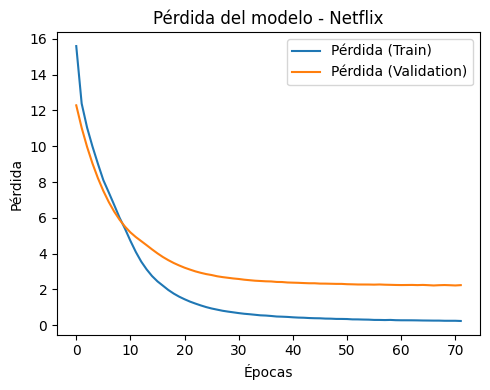

In [ ]:
import matplotlib.pyplot as plt

# Graficar la función de pérdida
plt.figure(figsize=(5, 4))
plt.plot(history.history['loss'], label='Pérdida (Train)')
plt.plot(history.history['val_loss'], label='Pérdida (Validation)')
plt.title('Pérdida del modelo - Netflix')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Mostrar la gráfica
plt.tight_layout()
plt.show()


## **Función para utilizar el sistema de recomendación**

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import random

def recommend_titles(genre=None, emotion=None, top_n=1):
    """
    Recomendar títulos a un usuario aleatorio basándose en el género y la emoción seleccionados,
    y predecir las calificaciones utilizando el modelo entrenado.

    :param genre: Género deseado para filtrar los títulos (str), opcional
    :param emotion: Emoción deseada para filtrar los títulos (str), opcional
    :param top_n: Número de recomendaciones a devolver (int)
    :return: DataFrame con los títulos recomendados y las calificaciones predichas
    """
    # Seleccionar un user_id aleatorio
    user_id = random.choice(df2['user_id'].unique())

    # Filtrar títulos según el género y la emoción (si se proporcionan)
    if genre:
        genre_mask = df2['genres'].apply(lambda genres: genre in genres if isinstance(genres, list) else False)
    else:
        genre_mask = np.ones(len(df2), dtype=bool)  # Sin filtro por género

    if emotion:
        emotion_mask = df2['predicted_emotions'].str.contains(emotion, case=False, na=False)
    else:
        emotion_mask = np.ones(len(df2), dtype=bool)  # Sin filtro por emoción

    filtered_titles = df2[genre_mask & emotion_mask]

    if filtered_titles.empty:
        return "No se encontraron títulos que coincidan con los criterios seleccionados."

    # Preparar entradas para el modelo
    user_array = np.array([user_id] * len(filtered_titles))  # Repetir el ID de usuario para los títulos filtrados
    title_array = filtered_titles['title'].values
    genres_array = genres_encoder.transform(filtered_titles['genres'])  # Ya está preprocesado como listas
    emotions_array = emotions_encoder.transform(filtered_titles['predicted_emotions'].fillna('').values.reshape(-1, 1)).toarray()
    release_year_array = filtered_titles['release_year_norm'].values
    duration_array = filtered_titles['duration_norm'].values

    # Predecir calificaciones
    predicted_ratings = model.predict([user_array, title_array, genres_array, emotions_array, release_year_array, duration_array])
    predicted_ratings = np.clip(predicted_ratings, 0, 5)  # Asegurar que los ratings estén entre 0 y 5

    # Añadir calificaciones predichas al DataFrame
    filtered_titles['predicted_rating'] = predicted_ratings
    filtered_titles['predicted_rating'] = filtered_titles['predicted_rating'].round(2)

    # Decodificar los títulos para obtener sus valores originales
    filtered_titles['title'] = title_encoder.inverse_transform(filtered_titles['title'])

    # Ordenar títulos por calificación predicha (de mayor a menor)
    recommended_titles = filtered_titles.sort_values(by='predicted_rating', ascending=False)

    # Devolver las top_n recomendaciones
    return recommended_titles[['title', 'predicted_rating']].head(top_n)

# ---------------- Ejemplo de recomendación ----------------

# Especificar el género y emoción deseados
genre = "Dramas"
emotion = "Sad"

recommendations = recommend_titles(genre, emotion)
recommendations


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


<ipython-input-17-b7f68390c20c>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_titles['predicted_rating'] = predicted_ratings
<ipython-input-17-b7f68390c20c>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_titles['predicted_rating'] = filtered_titles['predicted_rating'].round(2)
<ipython-input-17-b7f68390c20c>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

,title,predicted_rating
2323,God Bless the Broken Road,4.59


### Guardar el modelo para cargarlo y utilizarlo nuevamente en otro **entorno**

In [ ]:
# Guardar el modelo
model.save('netflix_recommendation_model.h5')


In [ ]:
from tensorflow.keras.models import load_model

# Cargar el modelo
model = load_model('netflix_recommendation_model.h5')
